<div style="text-align: center;">
    <img src="https://user-images.githubusercontent.com/86345471/221379942-51f24819-1f76-4289-8dee-06ea69f730f6.png" alt=Main "KPI />
</d></br>
Pr №2 — Зниження розмірності, кластеризація та текстова класифікація

## Завдання:
1. **PCA + t-SNE** — зниження розмірності та порівняння якості класифікації
2. **K-means quantization** — кластерний аналіз зображення
3. **Text classification** — обробка, візуалізація та класифікація текстів

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.metrics import classification_report, accuracy_score
from sklearn.ensemble import RandomForestClassifier

print('✅ Бібліотеки імпортовано успішно!')

✅ Бібліотеки імпортовано успішно!


## 1️⃣ Зниження розмірності (PCA + t-SNE)

In [2]:
# === Завантаження того ж датасету, що в ЛР1 ===
df = pd.read_csv('global_population_stats_2024.csv')

# Знаходимо колонку з Population
for col in df.columns:
    if 'Population(' in col:
        target_feature = col
        break

# Створюємо цільову змінну (класи за чисельністю населення)
bins = [-1, df[target_feature].quantile(0.33), df[target_feature].quantile(0.66), df[target_feature].max()]
labels = ['low', 'medium', 'high']
df['class'] = pd.cut(df[target_feature], bins=bins, labels=labels)

# Формуємо X, y
drop_cols = ['Country', 'class']
X = df.drop(columns=drop_cols)
y = df['class']
y_enc = LabelEncoder().fit_transform(y)

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Тренуємо модель до PCA
clf = RandomForestClassifier(random_state=42)
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y_enc, test_size=0.3, random_state=42)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
acc_before = accuracy_score(y_test, y_pred)
print('Точність ДО PCA:', round(acc_before,3))

Точність ДО PCA: 1.0


Відсоток дисперсії, пояснений двома компонентами: [0.42910957 0.27879267]


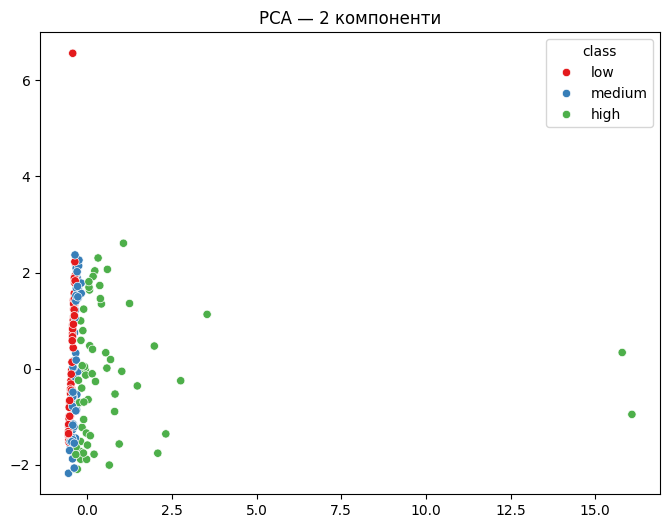

Точність ПІСЛЯ PCA: 0.948

✅ Висновок: PCA зменшує вимірність, пришвидшує навчання, але може трохи знизити точність.


In [3]:
# === PCA ===
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

print('Відсоток дисперсії, пояснений двома компонентами:', pca.explained_variance_ratio_)

plt.figure(figsize=(8,6))
sns.scatterplot(x=X_pca[:,0], y=X_pca[:,1], hue=df['class'], palette='Set1')
plt.title('PCA — 2 компоненти')
plt.show()

# Класифікація після PCA
X_train_pca, X_test_pca, y_train, y_test = train_test_split(X_pca, y_enc, test_size=0.3, random_state=42)
clf.fit(X_train_pca, y_train)
y_pred_pca = clf.predict(X_test_pca)
acc_after_pca = accuracy_score(y_test, y_pred_pca)
print('Точність ПІСЛЯ PCA:', round(acc_after_pca,3))

print('\n✅ Висновок: PCA зменшує вимірність, пришвидшує навчання, але може трохи знизити точність.')

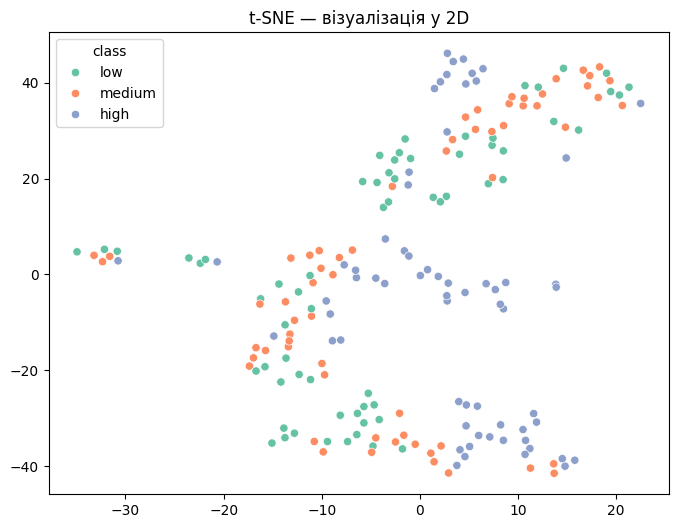

✅ t-SNE показує локальні кластери, але не зберігає глобальну структуру.


In [4]:
# === t-SNE ===
tsne = TSNE(n_components=2, perplexity=10, random_state=42)
X_tsne = tsne.fit_transform(X_scaled)

plt.figure(figsize=(8,6))
sns.scatterplot(x=X_tsne[:,0], y=X_tsne[:,1], hue=df['class'], palette='Set2')
plt.title('t-SNE — візуалізація у 2D')
plt.show()

print('✅ t-SNE показує локальні кластери, але не зберігає глобальну структуру.')

## 2️⃣ Кластерний аналіз — K-Means Quantization

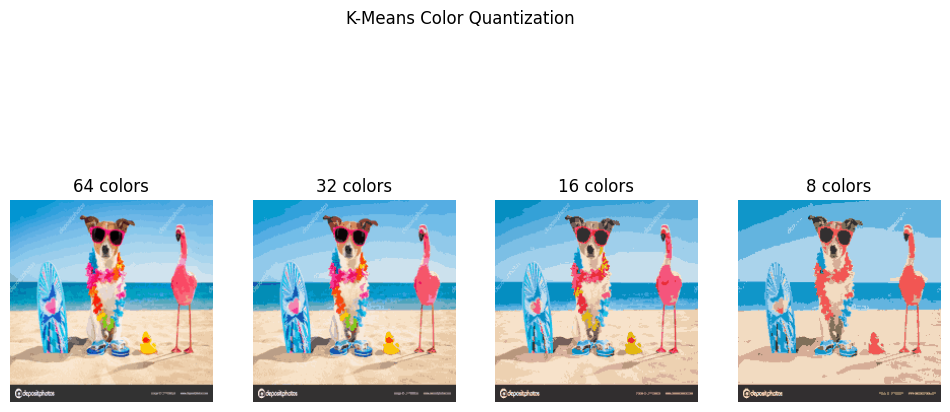

✅ Зменшення кількості кольорів пришвидшує обробку, але втрачає деталі.


In [5]:
from sklearn.cluster import KMeans
from PIL import Image

img = Image.open('image.jpg')
img = img.resize((200,200))
data = np.array(img) / 255.0
pixels = data.reshape(-1, 3)

levels = [64, 32, 16, 8]
plt.figure(figsize=(12,6))

for i, n_colors in enumerate(levels):
    kmeans = KMeans(n_clusters=n_colors, random_state=42)
    labels = kmeans.fit_predict(pixels)
    new_colors = kmeans.cluster_centers_[labels]
    quantized = new_colors.reshape(data.shape)
    plt.subplot(1, len(levels), i+1)
    plt.imshow(quantized)
    plt.title(f'{n_colors} colors')
    plt.axis('off')

plt.suptitle('K-Means Color Quantization')
plt.show()

print('✅ Зменшення кількості кольорів пришвидшує обробку, але втрачає деталі.')

## 3️⃣ Обробка та класифікація текстових даних

[nltk_data] Downloading package stopwords to /home/kali/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


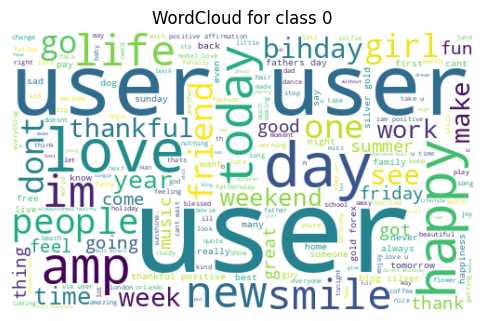

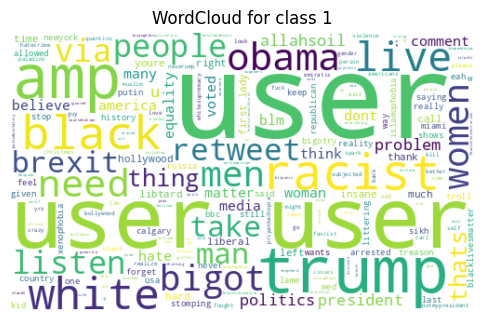

In [6]:
import nltk, re
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import make_pipeline
from wordcloud import WordCloud
from sklearn.utils import resample

nltk.download('stopwords')
from nltk.corpus import stopwords

# Використаємо невеликий текстовий датасет (дві категорії)
data = pd.read_csv('https://raw.githubusercontent.com/dD2405/Twitter_Sentiment_Analysis/master/train.csv')
data = data[['label','tweet']].rename(columns={'tweet':'text'})
data = data[data['label'].isin([0,1])].sample(2000, random_state=42)

stop_words = set(stopwords.words('english'))

def clean_text(text):
    text = re.sub(r'[^a-zA-Z ]', '', text)
    text = text.lower()
    words = [w for w in text.split() if w not in stop_words]
    return ' '.join(words)

data['clean'] = data['text'].apply(clean_text)

# WordCloud для кожного класу
for label in data['label'].unique():
    text = ' '.join(data[data['label']==label]['clean'])
    wc = WordCloud(width=500, height=300, background_color='white').generate(text)
    plt.figure(figsize=(6,4))
    plt.imshow(wc, interpolation='bilinear')
    plt.axis('off')
    plt.title(f'WordCloud for class {label}')
    plt.show()

In [7]:
# === TF-IDF + Naive Bayes класифікація ===

# Балансування класів
majority = data[data.label == 0]
minority = data[data.label == 1]
minority_upsampled = resample(minority, replace=True, n_samples=len(majority), random_state=42)
data_balanced = pd.concat([majority, minority_upsampled])

print('Баланс класів:')
print(data_balanced['label'].value_counts())

X_train, X_test, y_train, y_test = train_test_split(data_balanced['clean'], data_balanced['label'], test_size=0.3, random_state=42)

model = make_pipeline(TfidfVectorizer(max_features=2000), MultinomialNB())
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

print('Accuracy:', round(accuracy_score(y_test, y_pred),3))
print('\nClassification Report:')
print(classification_report(y_test, y_pred, zero_division=0))

Баланс класів:
label
0    1867
1    1867
Name: count, dtype: int64
Accuracy: 0.947

Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.90      0.95       569
           1       0.91      0.99      0.95       552

    accuracy                           0.95      1121
   macro avg       0.95      0.95      0.95      1121
weighted avg       0.95      0.95      0.95      1121

